In [1]:
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

import lsst.afw.table as afwTable
from lsst.utils import getPackageDir
import lsst.log as log
import lsst.meas.deblender
from lsst.meas.deblender import proximal, display, sim, baseline
import lsst.meas.deblender.utils as debUtils

import deblender

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
log.setLevel("", log.INFO)

plogger = logging.getLogger("proxmin")
plogger.setLevel(logging.INFO)

dlogger = logging.getLogger("deblender")
dlogger.setLevel(logging.INFO)

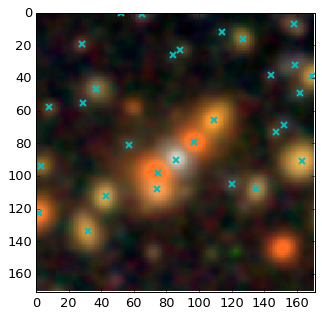

In [19]:
from astropy.table import Table
from astropy.io import fits

filters = ["g", "r", "i", "z"]

dataPath = os.path.abspath(os.path.join(lsst.utils.getPackageDir("testdata_deblender"),
                                        'real_data', 'cosmos_examples'))

peakTable = Table.read(os.path.join(dataPath, "example_26_cat.fits"))
imageList = []
for f in filters:
    img = fits.open(os.path.join(dataPath, "example_26_{0}.fits".format(f)))[0].data
    imageList.append(img)
images = np.array([i.tolist() for i in imageList])
peaks = [(peak["x"], peak["y"]) for peak in peakTable]
plt.figure(figsize=(7,7))
#img = display.imagesToRgb(images, contrast=10)
#plt.imshow(img)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
display.plotColorImage(images, ax=ax, show=False)
ax.plot(peakTable["x"], peakTable["y"], "cx", mew=2)
ax.set_xlim([0,images.shape[2]])
ax.set_ylim([images.shape[1], 0])
plt.show()

In [27]:
result = deblender.nmf.deblend(
    img=images,
    max_iter=2000,
    peaks=peaks,
    strict_constraints="M",
    constraints="S",
    #l0_thresh=.5,
    e_rel=1e-2,
    #psf_thresh=1e-2,
    monotonicUseNearest=True,
    algorithm="GLMM")

INFO:proxmin.algorithms:Completed 883 iterations


In [28]:
A, S, model, P_, Tx, Ty, errors = result

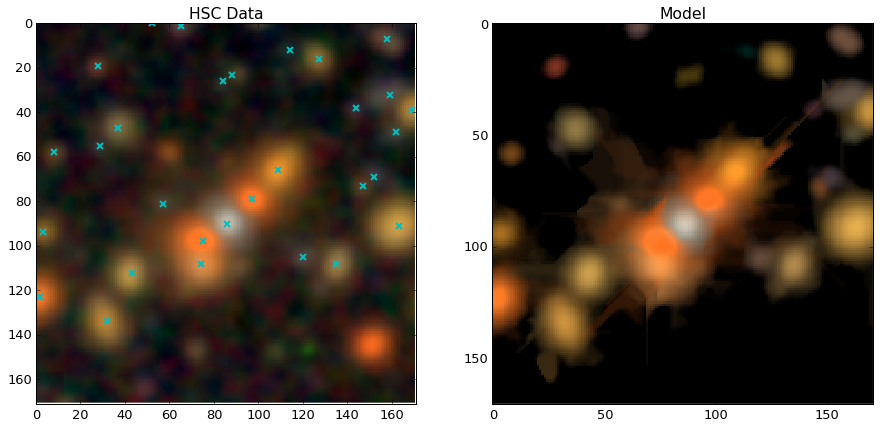

In [47]:
def modelColorPlot(images, model, Q=10):
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title("HSC Data")
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Model")
    display.plotColorImage(images, ax=ax1, show=False, Q=Q)
    ax1.plot(peakTable["x"], peakTable["y"], "cx", mew=2)
    ax1.set_xlim([0,images.shape[2]])
    ax1.set_ylim([images.shape[1], 0])
    
    display.plotColorImage(model, ax=ax2, show=False, Q=Q)
    
    plt.show()
modelColorPlot(images, model)

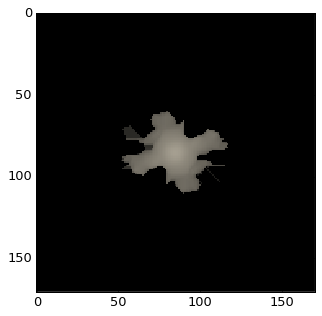

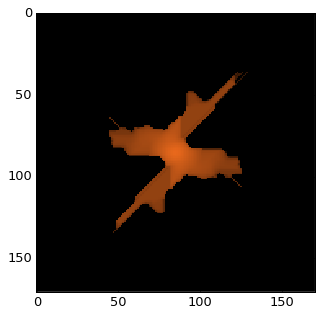

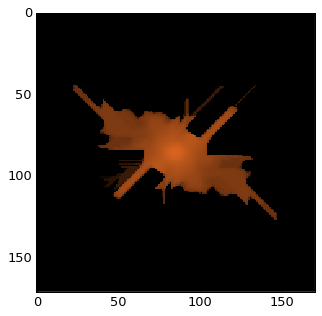

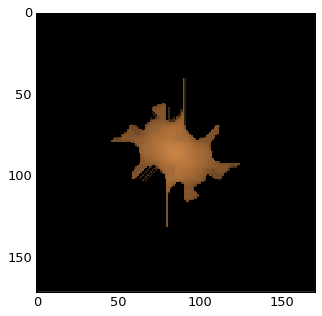

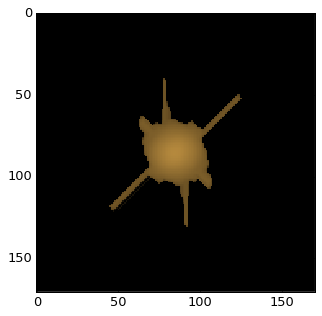

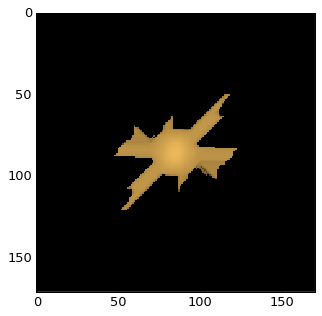

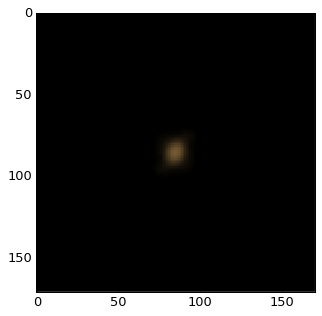

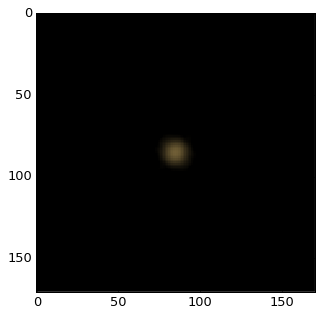

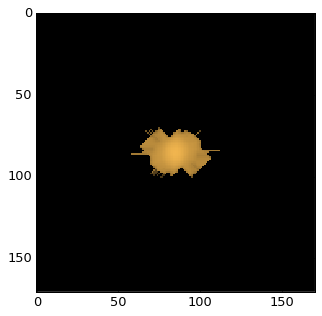

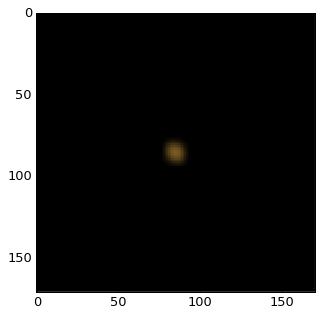

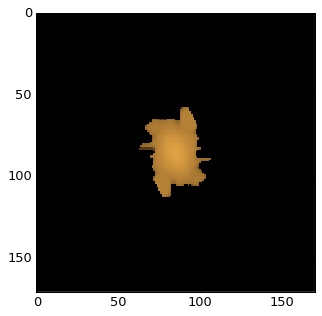

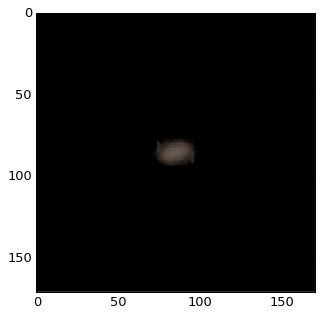

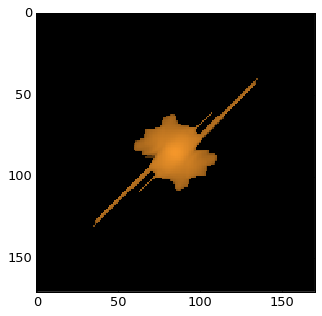

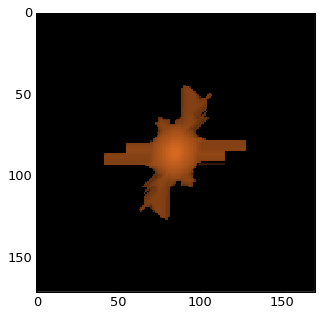

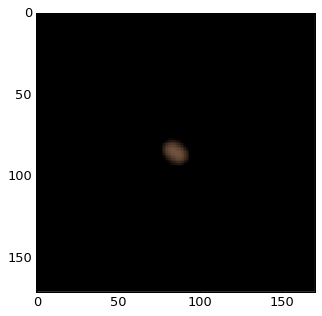

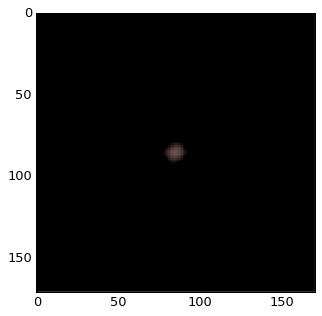

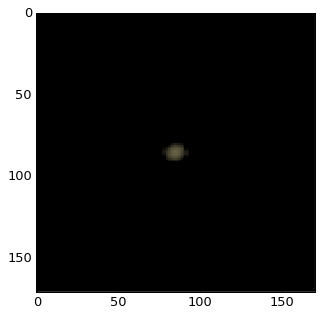

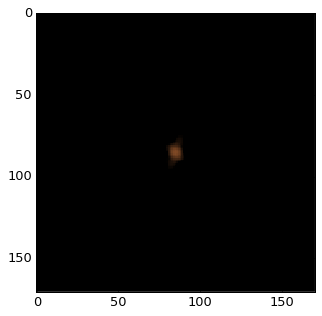

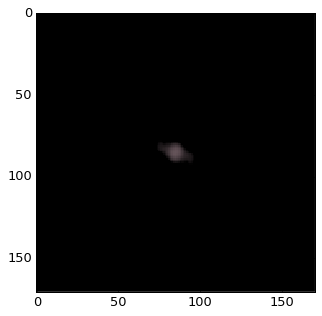

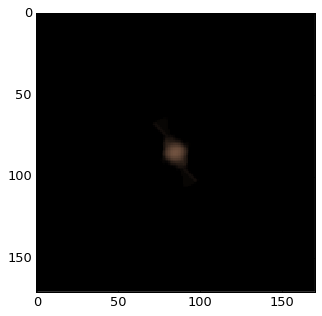

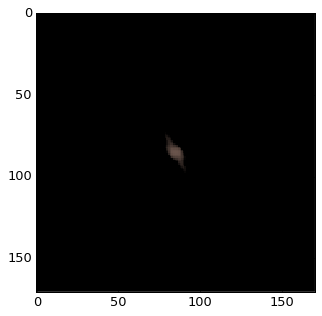

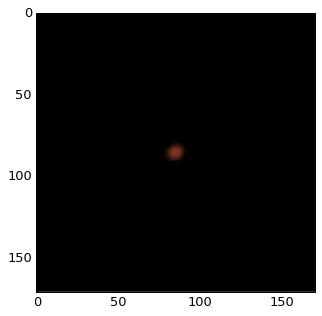

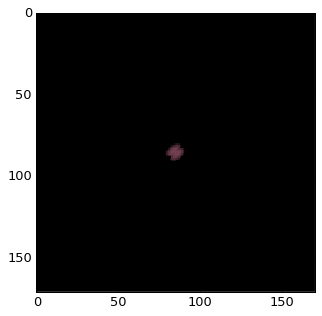

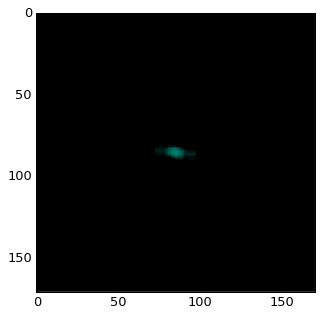

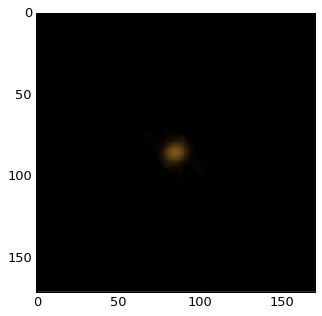

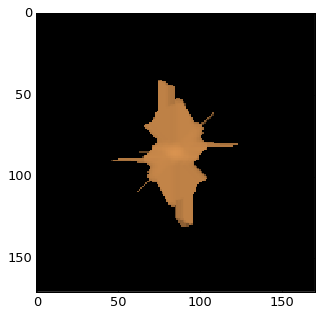

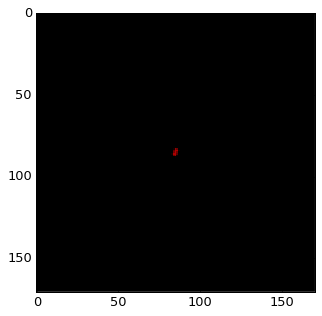

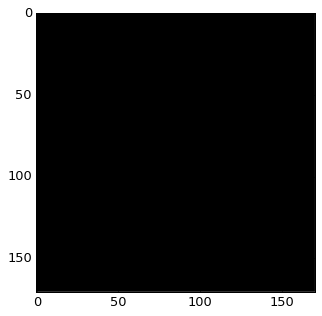

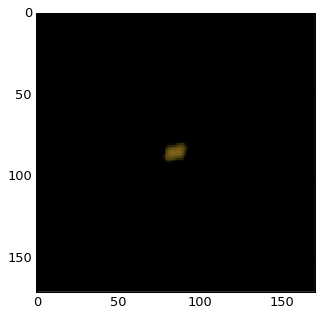

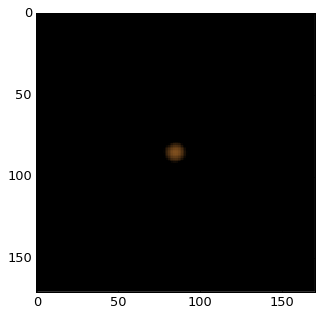

In [46]:
for k in range(S.shape[0]):
    Sk = S[k].reshape(model[0].shape)
    sk_images = np.array([(Ab[k]*Sk).tolist() for Ab in A])
    display.plotColorImage(sk_images, Q=100)